# Import

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler


plt.rcParams['figure.figsize'] = [21, 9]
plt.rcParams['figure.dpi'] = 300

# 다크모드에 맞는 스타일 설정
plt.style.use('dark_background')

# 추가적인 커스터마이징 (옵션)
plt.rcParams.update({
    'axes.edgecolor': 'white',         # 축의 테두리 색상
    'axes.labelcolor': 'white',       # 축 라벨 색상
    'xtick.color': 'white',           # x축 눈금 색상
    'ytick.color': 'white',           # y축 눈금 색상
    'grid.color': 'gray',             # 그리드 라인 색상
    'grid.alpha': 0.3,                # 그리드 투명도
    'text.color': 'white',            # 텍스트 색상
    'figure.facecolor': '#121212',    # 전체 그림 배경색
    'axes.facecolor': '#121212',      # 축 배경색
    'legend.facecolor': '#1e1e1e',    # 범례 배경색
    'legend.edgecolor': 'white',      # 범례 테두리 색상
})
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
REDRAW = False

Original dataset: https://www.kaggle.com/datasets/schran/insurance-premium-prediction/data

# Load Data

In [99]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)

In [100]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column]
del train_data, test_data

In [101]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days

In [102]:
# # annual income 전처리
# data.annual_income = np.log(data.annual_income).fillna(12)

In [103]:
int_columns = data.select_dtypes(include=['int64']).columns
float_columns = data.select_dtypes(include=['float64']).columns
categorical_columns = data.select_dtypes(include='object').columns
numerical_columns = int_columns.tolist() + float_columns.tolist()

In [104]:
# --- 2. 결측치 처리 ---
# 범주형 변수의 결측치를 'unknown'으로 대체
categorical_columns = data.select_dtypes(include='object').columns
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)

# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    
int_columns = data.select_dtypes(include=['int64']).columns
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
numerical_columns = float_columns.append(int_columns)

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
data[target_column] = y

# Devide Dataset

In [105]:
y = data.premium_amount.dropna().values

y_scaler = StandardScaler().fit(np.log1p(y).reshape(-1,1))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

In [93]:
importance.tail(5).index

Index(['policy_type', 'location', 'property_type', 'smoking_status', 'gender'], dtype='object')

In [106]:
# drop features: 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'

X = data.loc[data[target_column].notnull(), ].drop(columns=[target_column, 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'])

In [109]:
def inverse_y(y):
    return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

In [110]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.2, random_state=42)

# Modeling

In [111]:
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

def rmsle(y_true, y_pred):
    y_true = inverse_y(y_true)
    y_pred = inverse_y(y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
# TODO: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=1)
rf.fit(X_train, y_train)

In [93]:
rf.score(X_val, y_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished


-0.0014465343707852352

In [196]:
from xgboost import XGBRFRegressor
xgbrf = XGBRFRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=1, gpu_id=0)
xgbrf.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=0,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=20, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=500, n_jobs=-1,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, ...)

In [197]:
evaluate_model(xgbrf, X_val, y_val)

(0.06902026686920126, 0.9319795406727515, 1.0578987187101034)

In [87]:
# TODO: XGBoost Regressor
from xgboost import XGBRegressor
import xgboost as xgb
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, metric_name='rmse', data_name='validation_0', save_best=True
)
xgbr = XGBRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    objective='reg:squarederror',
    # eval_metric='r2',
    gpu_id=0,
    # num_parallel_tree=1,
    callbacks=[early_stop]
)
xgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)])
evaluate_model(xgbr, X_val, y_val)

[0]	validation_0-rmse:0.99226
[1]	validation_0-rmse:0.98567
[2]	validation_0-rmse:0.98047
[3]	validation_0-rmse:0.97628
[4]	validation_0-rmse:0.97290
[5]	validation_0-rmse:0.97023
[6]	validation_0-rmse:0.96815
[7]	validation_0-rmse:0.96648
[8]	validation_0-rmse:0.96514
[9]	validation_0-rmse:0.96408
[10]	validation_0-rmse:0.96337
[11]	validation_0-rmse:0.96283
[12]	validation_0-rmse:0.96234
[13]	validation_0-rmse:0.96214
[14]	validation_0-rmse:0.96203
[15]	validation_0-rmse:0.96194
[16]	validation_0-rmse:0.96180
[17]	validation_0-rmse:0.96181
[18]	validation_0-rmse:0.96183
[19]	validation_0-rmse:0.96189
[20]	validation_0-rmse:0.96202
[21]	validation_0-rmse:0.96218
[22]	validation_0-rmse:0.96227
[23]	validation_0-rmse:0.96242
[24]	validation_0-rmse:0.96250
[25]	validation_0-rmse:0.96270
[26]	validation_0-rmse:0.96288


(0.07594079710075996, 0.9250515782726142, 1.0539593865551793)

In [68]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, 
           shuffle=False, 
        #    random_state=42
)
[(train_idx, val_idx) for train_idx, val_idx in kf.split(X)][3]


(array([      0,       1,       2, ..., 1199997, 1199998, 1199999]),
 array([720000, 720001, 720002, ..., 959997, 959998, 959999]))

In [113]:
# TODO: LightGBM Regressor
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=30,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=1,
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 14
[LightGBM] [Info] Start training from score -0.000037


LGBMRegressor(max_depth=30, min_child_samples=7, min_child_weight=0.003,
              n_estimators=500, n_jobs=-1, random_state=42, verbosity=1)

In [114]:
evaluate_model(lgbm, X_val, y_val)

(0.08879492199920735, 0.9121836489372265, 1.0466031641358802)

In [ ]:
(0.08857439677075307, 0.9124044109944525, 1.0467298032672498)

In [203]:
evaluate_model(lgbm, X_val, y_val)

(0.07981171525655373, 0.9211765030197014, 1.0517495324313206)

In [138]:
lgbm.score(X_val, y_val)

0.07646312027622981

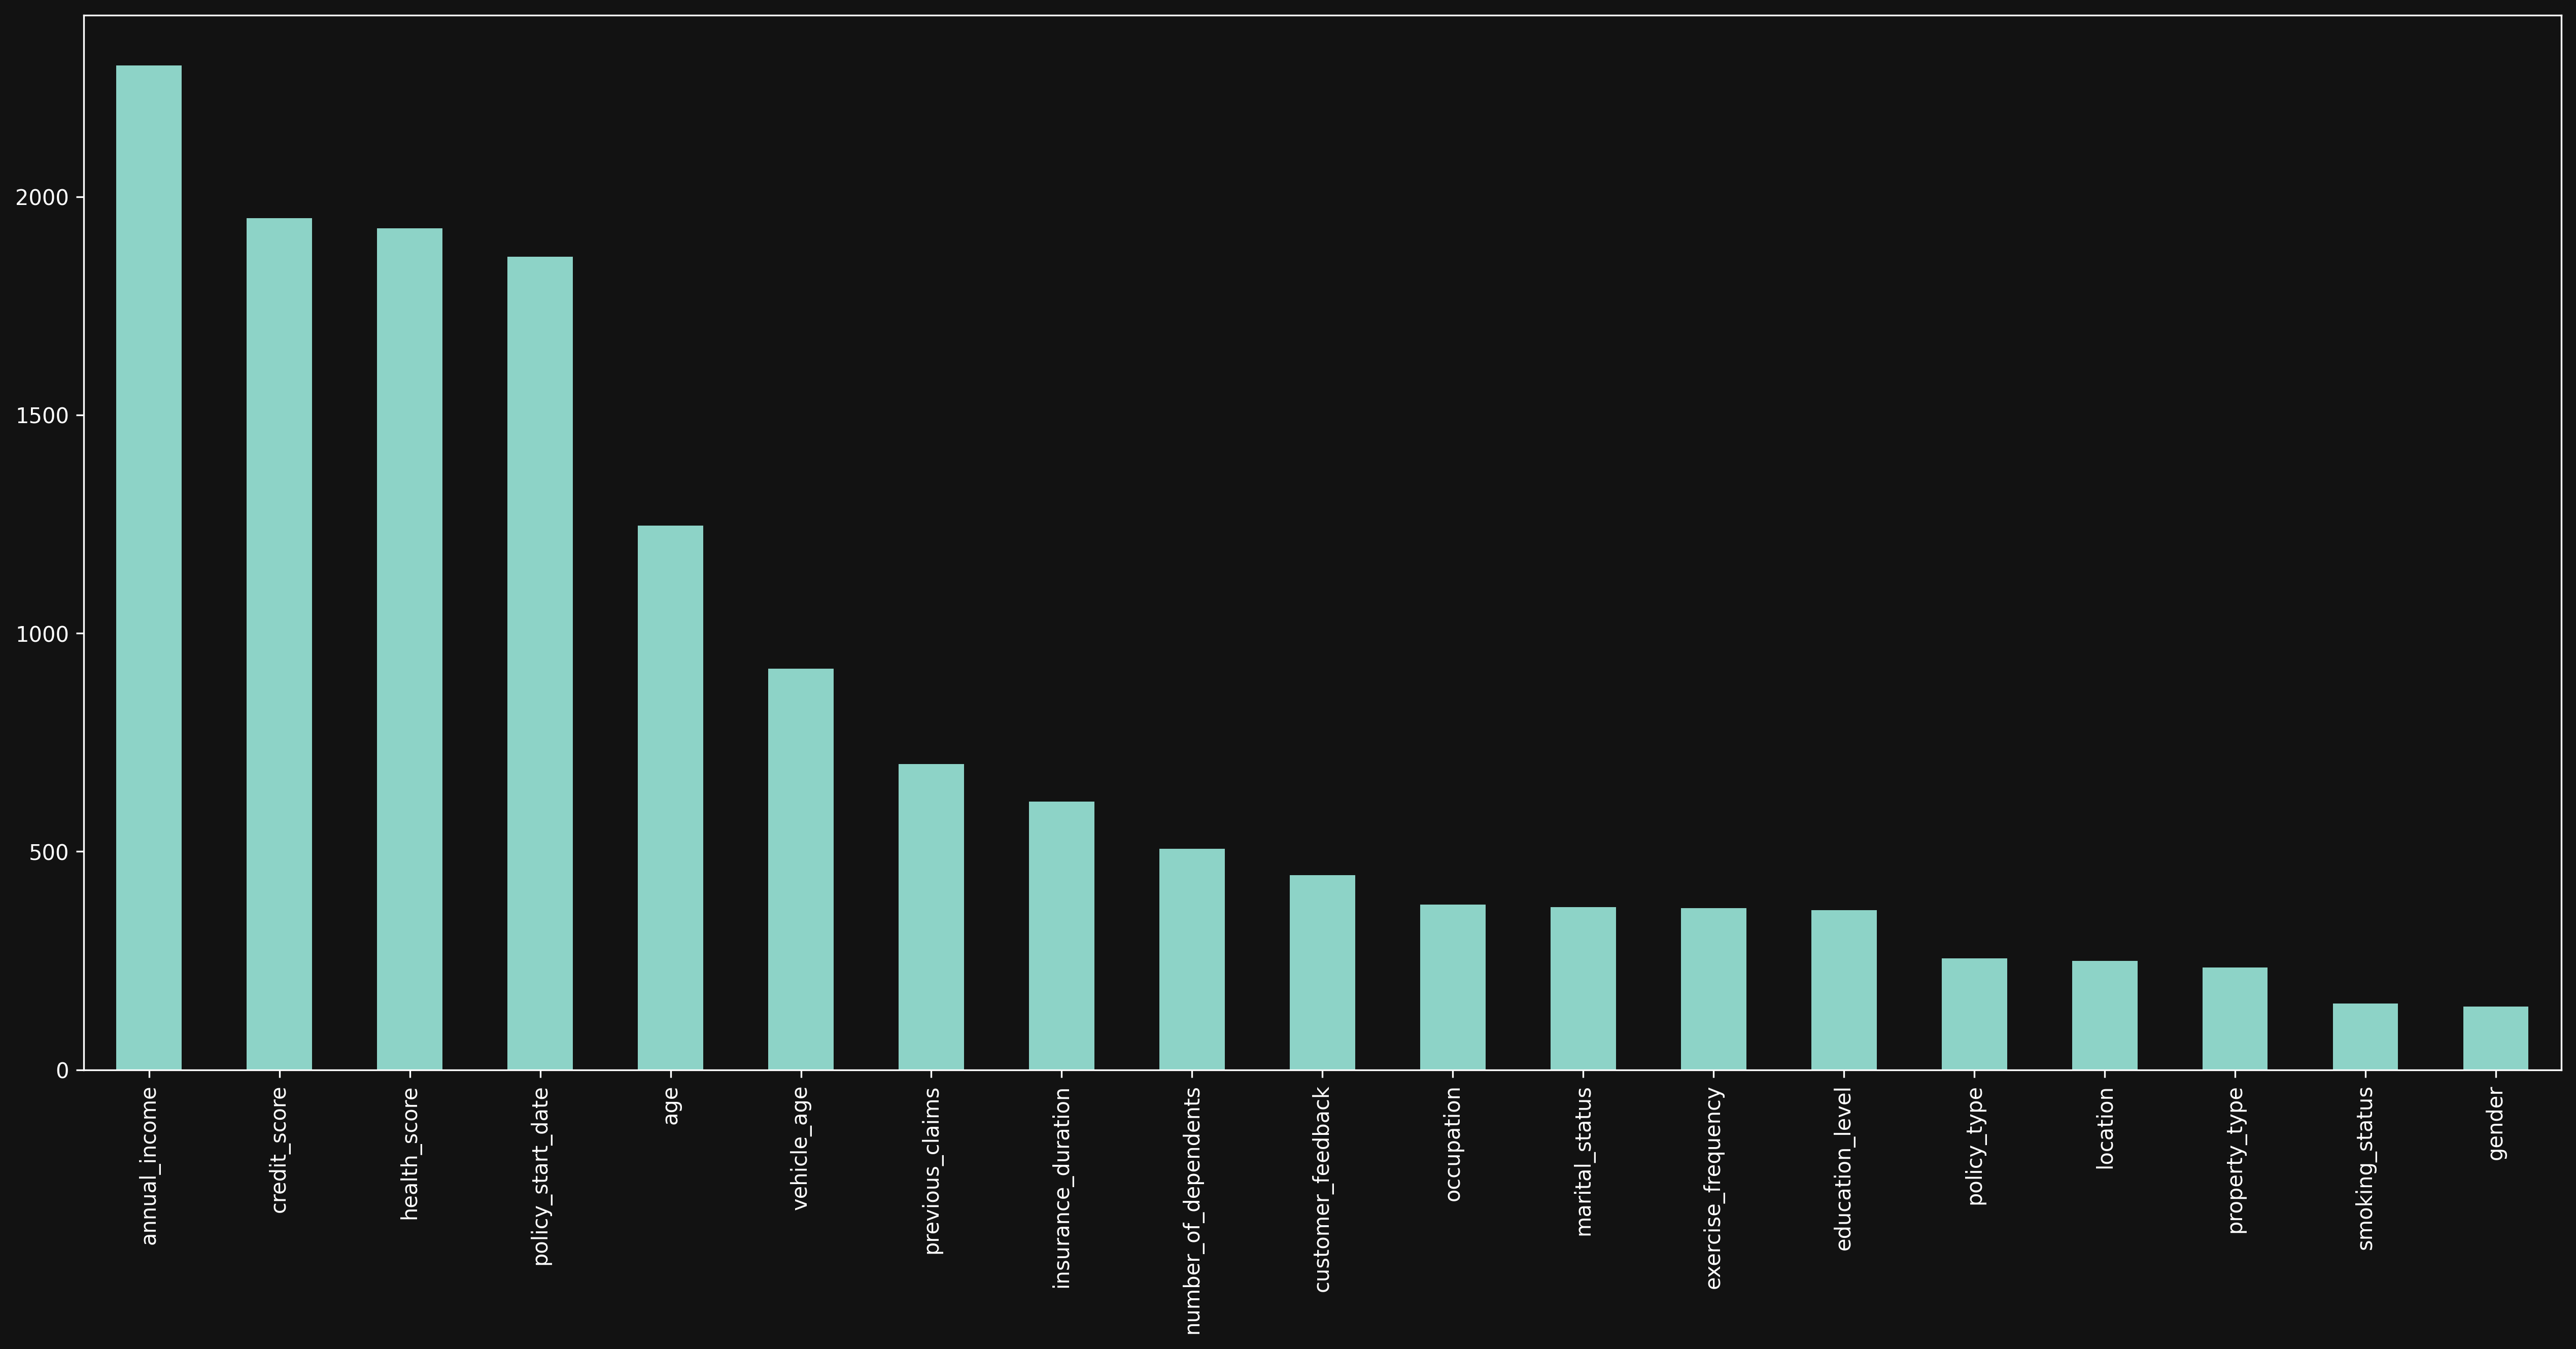

In [90]:
pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

In [209]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # verbosity=1,
)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 22
[LightGBM] [Info] Start training from score -0.000037


LGBMRegressor(max_depth=20, n_estimators=500, n_jobs=-1, random_state=42,
              verbosity=1)

In [210]:
evaluate_model(lgbm, X_val, y_val)

(0.07987072638697967, 0.921117428515422, 1.0517158078529159)

In [ ]:
# SVM
from sklearn.svm import SVR
svr = SVR(
    C=1,
    epsilon=2.25,
)
svr.fit(X_train, y_train)

In [218]:
import pickle
svr = pd.read_pickle('svr.pkl')

In [75]:
# save svr model because it takes too long to train
import pickle
with open('svr.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [220]:
evaluate_model(svr, X_val[:, 1:], y_val)

(-0.41186115869286777, 1.4133773994706387, 1.3027766711381177)

# Submission

In [50]:
test = data[data[target_column].isna()].drop(columns=[target_column])

In [52]:
def make_ans(model):
    ans=inverse_y(model.predict(test.values))
    return pd.Series(ans, index = test.index).rename('Premium Amount')

In [54]:
ans = make_ans(lgbm)
ans.to_csv('submission.csv', header=True)